In [ ]:
import os
import random
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc as sk_auc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms

from light_cnn_v4 import LightCNN_V4


# ===============================
# DEVICE
# ===============================
device = torch.device(1)

# ===============================
# MODEL
# ===============================
model = LightCNN_V4(None)
state_dict = torch.load(r'LightCNN-V4_checkpoint.pth.tar', map_location=device)['state_dict']
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

# ===============================
# TRANSFORMS
# ===============================
lightcnn4_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])



<ipython-input-5-fd65baca26e4>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r'lightcnn/LightCNN-V4_checkpoint.pth.tar', map_location=device)['st

In [7]:
# ========================================
# 1. FUNCTIONS FOR ROC + TAR@FAR
# ========================================
def compute_roc_sklearn(pos_scores, neg_scores):
    pos_scores = np.asarray(pos_scores)
    neg_scores = np.asarray(neg_scores)

    scores = np.concatenate([pos_scores, neg_scores])
    labels = np.concatenate([
        np.ones_like(pos_scores, dtype=int),
        np.zeros_like(neg_scores, dtype=int)
    ])

    fars, tars, thresholds = roc_curve(labels, scores, pos_label=1)
    roc_auc = sk_auc(fars, tars)
    return fars, tars, thresholds, roc_auc


def tar_at_far_sklearn(fars, tars, target_far):
    """Interpolate TAR at FAR."""
    return float(np.interp(target_far, fars, tars))



In [ ]:
# ========================================
# 3B. DATA PATHS — deformable with id with pose
# ========================================

afw_dir_orig_id_pose = r'/media/oem/storage01/Shakeel/aerial-segmentation/SAM_finetuning/abc/cycleGAN_all/final/deformable_cycleGAN_w_id_w_pose/datasets/multipie/AFW_cropped/'
afw_dir_syn_id_pose = r'/media/oem/storage01/Shakeel/aerial-segmentation/SAM_finetuning/abc/cycleGAN_all/final/deformable_cycleGAN_w_id_w_pose/results_afw_second_last/multipie_pretrained/test_latest/images_root'
groundtruth_dir_id_pose = r'/media/oem/storage01/Shakeel/aerial-segmentation/SAM_finetuning/abc/cycleGAN_all/final/deformable_cycleGAN_w_id_w_pose/results_afw_second_last/multipie_pretrained/test_latest/images_structure'


# ========================================
# 4B. PREPARE PROBES — deformable with id with pose
# ========================================

probe_list_id_pose = [
    os.path.join(afw_dir_syn_id_pose, f.split('.')[0] + '_0.png')
    for f in os.listdir(groundtruth_dir_id_pose)
    if f.endswith('.png')
]

synthetic_content_id_pose = os.listdir(afw_dir_syn_id_pose)

probe_labels_id_pose = []
probe_emb_id_pose = []

with torch.no_grad():
    for probe_img in probe_list_id_pose:
        img = Image.open(probe_img)
        img = lightcnn4_transform(img)[None, :, :, :]
        emb = model(img.to(device))

        probe_emb_id_pose.append(emb)

        id_label = os.path.basename(probe_img).split('.')[0]
        probe_labels_id_pose.append(id_label.split('_0')[0])


# ========================================
# 5B. COMPUTE POSITIVE / NEGATIVE SCORES — deformable with id with pose
# ========================================

positive_scores_id_pose = []
negative_scores_id_pose = []

for prob_emb, probe_label in zip(probe_emb_id_pose, probe_labels_id_pose):

    # -------- Positive matches
    pos_files = [f for f in synthetic_content_id_pose if f.startswith(probe_label + "_")]

    for pos_f in pos_files:
        full_path = os.path.join(afw_dir_syn_id_pose, pos_f)
        img = Image.open(full_path)
        img = lightcnn4_transform(img)[None, :, :, :]

        with torch.no_grad():
            emb = model(img.to(device))
            emb = emb.detach().cpu().numpy()
            probe_np = prob_emb.detach().cpu().numpy()

            sim = cosine_similarity(probe_np, emb).squeeze()
            positive_scores_id_pose.append(sim)

    # -------- Negative matches
    neg_files = [f for f in synthetic_content_id_pose if not f.startswith(probe_label + "_")]
    neg_files = random.sample(neg_files, min(500, len(neg_files)))

    for neg_f in neg_files:
        full_path = os.path.join(afw_dir_syn_id_pose, neg_f)
        img = Image.open(full_path)
        img = lightcnn4_transform(img)[None, :, :, :]

        with torch.no_grad():
            emb = model(img.to(device))
            emb = emb.detach().cpu().numpy()
            probe_np = prob_emb.detach().cpu().numpy()

            sim = cosine_similarity(probe_np, emb).squeeze()
            negative_scores_id_pose.append(sim)




NameError: name 'compute_roc_sklearn' is not defined


===== Verification Metrics (Deformable w_ID w_Pose) =====
AUC ROC: 0.8895
TAR @ FAR=0.001: 0.4219
TAR @ FAR=0.01: 0.5694
TAR @ FAR=0.1: 0.7546


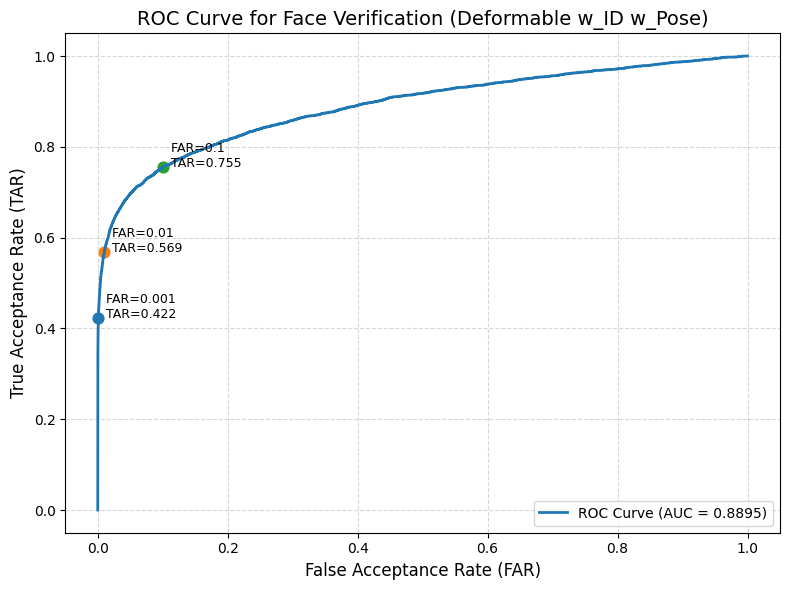

In [8]:
# ========================================
# 6B. COMPUTE ROC, AUC, TAR@FAR — deformable with id with pose
# ========================================

fars_id_pose, tars_id_pose, thr_id_pose, auc_id_pose = compute_roc_sklearn(
    positive_scores_id_pose,
    negative_scores_id_pose
)

target_fars = [0.001, 0.01, 0.1]
tar_results_id_pose = {
    far: tar_at_far_sklearn(fars_id_pose, tars_id_pose, far)
    for far in target_fars
}

print("\n===== Verification Metrics (Deformable w_ID w_Pose) =====")
print(f"AUC ROC: {auc_id_pose:.4f}")
for far, tar in tar_results_id_pose.items():
    print(f"TAR @ FAR={far}: {tar:.4f}")


# ========================================
# 7B. ROC VISUALIZATION — deformable with id with pose
# ========================================

plt.figure(figsize=(8, 6))
plt.plot(fars_id_pose, tars_id_pose, linewidth=2,
         label=f"ROC Curve (AUC = {auc_id_pose:.4f})")

for far, tar in tar_results_id_pose.items():
    plt.scatter([far], [tar], s=60)
    plt.text(far, tar, f"  FAR={far}\n  TAR={tar:.3f}", fontsize=9)

plt.xlabel("False Acceptance Rate (FAR)", fontsize=12)
plt.ylabel("True Acceptance Rate (TAR)", fontsize=12)
plt.title("ROC Curve for Face Verification (Deformable w_ID w_Pose)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


<ipython-input-9-2fa6fcf32ccb>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r'lightcnn/LightCNN-V4_checkpoint.pth.tar', map_location=device)['st


===== Verification Metrics (Overall) =====
AUC ROC: 0.8270
TAR @ FAR=0.001: 0.3363
TAR @ FAR=0.01: 0.4405
TAR @ FAR=0.1: 0.6295


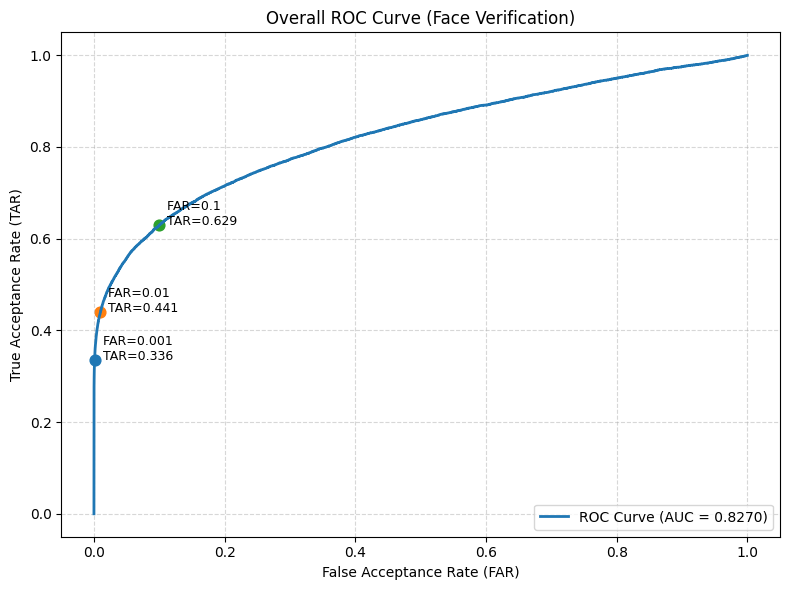

In [9]:
import os
import random
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

from lightcnn.light_cnn_v4 import LightCNN_V4
from dataset_lightcnnv4 import ImageDataset

# ===============================
# DEVICE
# ===============================
device = torch.device(1)

# ===============================
# MODEL
# ===============================
model = LightCNN_V4(None)
state_dict = torch.load(r'lightcnn/LightCNN-V4_checkpoint.pth.tar', map_location=device)['state_dict']
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

# ===============================
# TRANSFORMS
# ===============================
lightcnn4_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

# ===============================
# DATA PATH
# ===============================
data_path = r'/media/oem/storage01/Shakeel/aerial-segmentation/SAM_finetuning/abc/cycleGAN_all/final/deformable_cycleGAN_w_id_w_pose/results_secondlast_checkpoint_pose_corrected/multipie_pretrained/test_latest/secondlast_checkpoint_pose_corrected'

# ===============================
# HELPER FUNCTIONS
# ===============================
def compute_roc_sklearn(pos_scores, neg_scores):
    y_true = np.array([1]*len(pos_scores) + [0]*len(neg_scores))
    y_score = np.array(pos_scores + neg_scores)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, auc

def tar_at_far_sklearn(fpr, tpr, target_far):
    idx = np.where(fpr <= target_far)[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

# ===============================
# PREPARE PROBES
# ===============================
probe_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]

probe_labels = []
probe_emb = []

with torch.no_grad():
    for probe_img in probe_list:
        img = Image.open(probe_img)
        img = lightcnn4_transform(img)[None,:,:,:]
        emb = model(img.to(device))
        probe_emb.append(emb)
        id_label = os.path.basename(probe_img).split('.')[0]
        probe_labels.append(id_label)

# ===============================
# POSES
# ===============================
poses = {
    '90': ('110', '240'),
    '75': ('120', '010'),
    '60': ('090', '200'),
    '45': ('080', '190'),
    '30': ('130', '041'),
    '15': ('140', '050')
}

# ===============================
# COMPUTE OVERALL POSITIVE / NEGATIVE SCORES
# ===============================
positive_scores = []
negative_scores = []

for pose_code in poses.keys():
    dataset = ImageDataset(data_path, lightcnn4_transform, pose_code)
    dataloader = DataLoader(dataset, batch_size=64, num_workers=12)

    for j in range(len(probe_emb)):
        curr_probe_emb = probe_emb[j].reshape(1, -1).detach().cpu().numpy()
        curr_probe_label = probe_labels[j]

        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = list(labels)

            with torch.no_grad():
                embeddings = model(imgs).detach().cpu().numpy()
                _probe_labels = [curr_probe_label] * len(labels)

                # Cosine similarity
                sims = cosine_similarity(curr_probe_emb, embeddings).squeeze()

                # Positive matches
                for sim, gt_label in zip(sims, labels):
                    if curr_probe_label == gt_label:
                        positive_scores.append(sim)
                    else:
                        negative_scores.append(sim)

# ===============================
# COMPUTE ROC, AUC, TAR@FAR
# ===============================
fpr, tpr, thresholds, auc = compute_roc_sklearn(positive_scores, negative_scores)

target_fars = [0.001, 0.01, 0.1]
tar_results = {far: tar_at_far_sklearn(fpr, tpr, far) for far in target_fars}

print("\n===== Verification Metrics (Overall) =====")
print(f"AUC ROC: {auc:.4f}")
for far, tar in tar_results.items():
    print(f"TAR @ FAR={far}: {tar:.4f}")

# ===============================
# ROC PLOT
# ===============================
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC Curve (AUC = {auc:.4f})")
for far, tar in tar_results.items():
    plt.scatter([far], [tar], s=60)
    plt.text(far, tar, f"  FAR={far}\n  TAR={tar:.3f}", fontsize=9)
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("True Acceptance Rate (TAR)")
plt.title("Overall ROC Curve (Face Verification)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()




===== Verification Metrics (Dataset 1: deformable w_ID w_Pose) =====
AUC ROC: 0.8895
TAR @ FAR=0.001: 0.4219
TAR @ FAR=0.01: 0.5694
TAR @ FAR=0.1: 0.7546

===== Verification Metrics (Dataset 2) =====
AUC ROC: 0.8270
TAR @ FAR=0.001: 0.3363
TAR @ FAR=0.01: 0.4405
TAR @ FAR=0.1: 0.6295


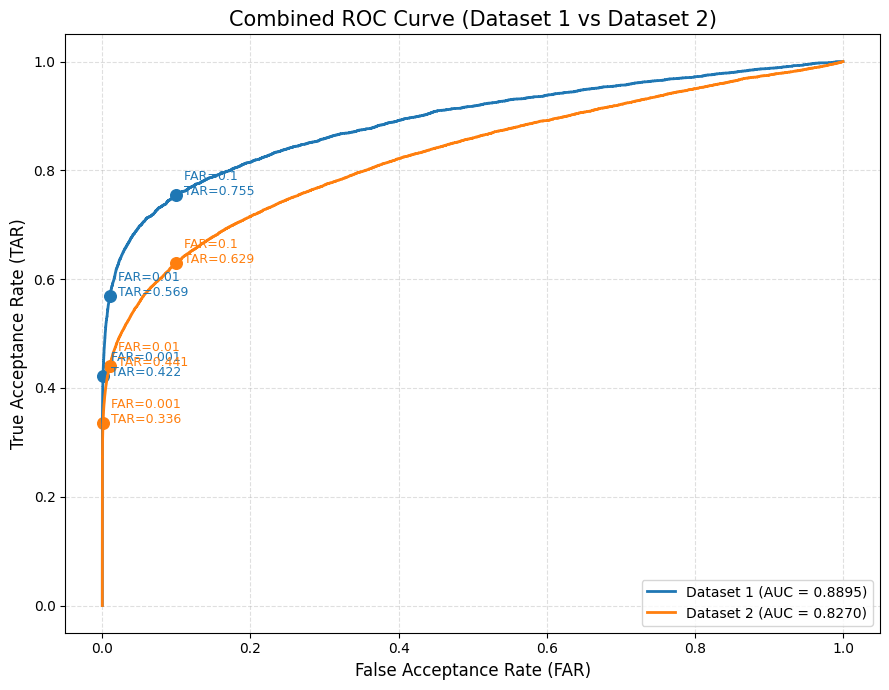

In [10]:
# ========================================
# 6B. COMPUTE ROC, AUC, TAR@FAR
# ========================================

# Dataset 1 (deformable w_ID w_Pose)
fars_id_pose, tars_id_pose, thr_id_pose, auc_id_pose = compute_roc_sklearn(
    positive_scores_id_pose,
    negative_scores_id_pose
)

# Dataset 2
fpr, tpr, thresholds, auc = compute_roc_sklearn(
    positive_scores,
    negative_scores
)

# TAR @ FAR values (same for both)
target_fars = [0.001, 0.01, 0.1]

tar_results_id_pose = {
    far: tar_at_far_sklearn(fars_id_pose, tars_id_pose, far)
    for far in target_fars
}

tar_results = {
    far: tar_at_far_sklearn(fpr, tpr, far)
    for far in target_fars
}

# ========================================
# PRINT METRICS
# ========================================

print("\n===== Verification Metrics (Dataset 1: deformable w_ID w_Pose) =====")
print(f"AUC ROC: {auc_id_pose:.4f}")
for far, tar in tar_results_id_pose.items():
    print(f"TAR @ FAR={far}: {tar:.4f}")

print("\n===== Verification Metrics (Dataset 2) =====")
print(f"AUC ROC: {auc:.4f}")
for far, tar in tar_results.items():
    print(f"TAR @ FAR={far}: {tar:.4f}")

# ========================================
# 7B. COMBINED ROC PLOT
# ========================================

plt.figure(figsize=(9, 7))

# Dataset 1 curve
line1, = plt.plot(
    fars_id_pose, tars_id_pose, linewidth=2,
    label=f"Dataset 1 (AUC = {auc_id_pose:.4f})"
)
color1 = line1.get_color()  # get line color

# Dataset 2 curve
line2, = plt.plot(
    fpr, tpr, linewidth=2,
    label=f"Dataset 2 (AUC = {auc:.4f})"
)
color2 = line2.get_color()  # get line color

# Dataset 1 FAR markers + text
for far, tar in tar_results_id_pose.items():
    plt.scatter([far], [tar], s=70, color=color1)
    plt.text(far, tar, f"  FAR={far}\n  TAR={tar:.3f}", fontsize=9, color=color1)

# Dataset 2 FAR markers + text
for far, tar in tar_results.items():
    plt.scatter([far], [tar], s=70, color=color2)
    plt.text(far, tar, f"  FAR={far}\n  TAR={tar:.3f}", fontsize=9, color=color2)

plt.xlabel("False Acceptance Rate (FAR)", fontsize=12)
plt.ylabel("True Acceptance Rate (TAR)", fontsize=12)
plt.title("Combined ROC Curve (Dataset 1 vs Dataset 2)", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


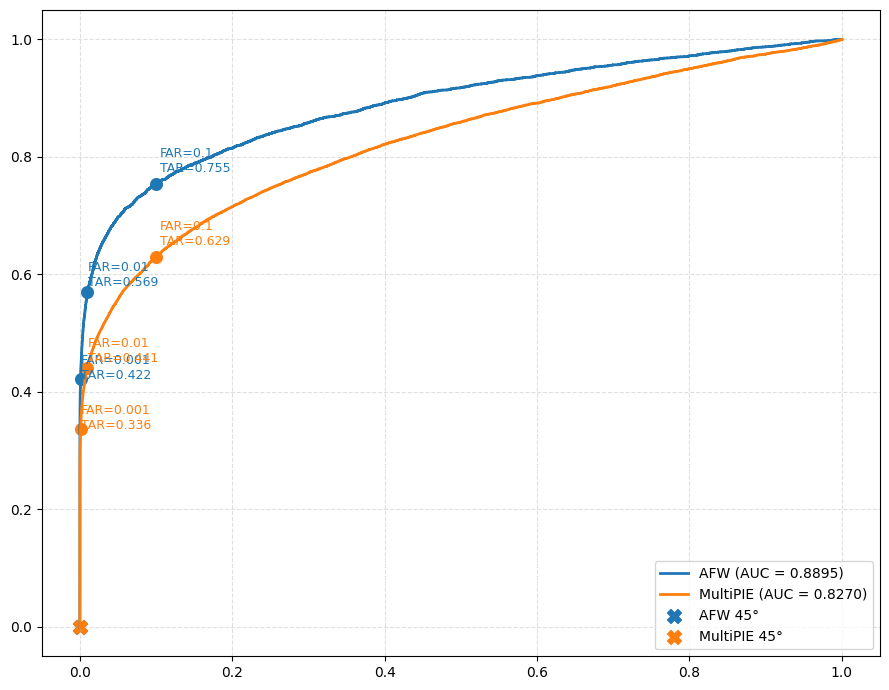

In [ ]:
plt.figure(figsize=(9, 7))

# Dataset 1 curve (AFW)
line1, = plt.plot(
    fars_id_pose, tars_id_pose, linewidth=2,
    label=f"AFW (AUC = {auc_id_pose:.4f})"
)
color1 = line1.get_color()  # get line color

# Dataset 2 curve (MultiPIE)
line2, = plt.plot(
    fpr, tpr, linewidth=2,
    label=f"MultiPIE (AUC = {auc:.4f})"
)
color2 = line2.get_color()  # get line color

# Dataset 1 FAR markers + text (AFW)
for i, (far, tar) in enumerate(tar_results_id_pose.items()):
    plt.scatter([far], [tar], s=70, color=color1)
    # Offset text to avoid overlap
    plt.text(far*1.05, tar + 0.01*i, f"FAR={far}\nTAR={tar:.3f}", fontsize=9, color=color1)

# Dataset 2 FAR markers + text (MultiPIE)
for i, (far, tar) in enumerate(tar_results.items()):
    plt.scatter([far], [tar], s=70, color=color2)
    # Offset text to avoid overlap
    plt.text(far*1.05, tar + 0.01*i, f"FAR={far}\nTAR={tar:.3f}", fontsize=9, color=color2)

# Remove axis labels
plt.xlabel("")
plt.ylabel("")

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

def tar_at_45deg(fars, tars):
    # Find index where |TAR - FAR| is minimal
    fars = np.array(fars)
    tars = np.array(tars)
    idx = np.argmin(np.abs(tars - fars))
    return fars[idx], tars[idx]

# Dataset 1 (AFW)
far_45_afw, tar_45_afw = tar_at_45deg(fars_id_pose, tars_id_pose)
print(f"AFW ROC 45° crossing: FAR={far_45_afw:.4f}, TAR={tar_45_afw:.4f}")

# Dataset 2 (MultiPIE)
far_45_multi, tar_45_multi = tar_at_45deg(fpr, tpr)
print(f"MultiPIE ROC 45° crossing: FAR={far_45_multi:.4f}, TAR={tar_45_multi:.4f}")



AFW ROC 45° crossing: FAR=0.0000, TAR=0.0000
MultiPIE ROC 45° crossing: FAR=0.0000, TAR=0.0000


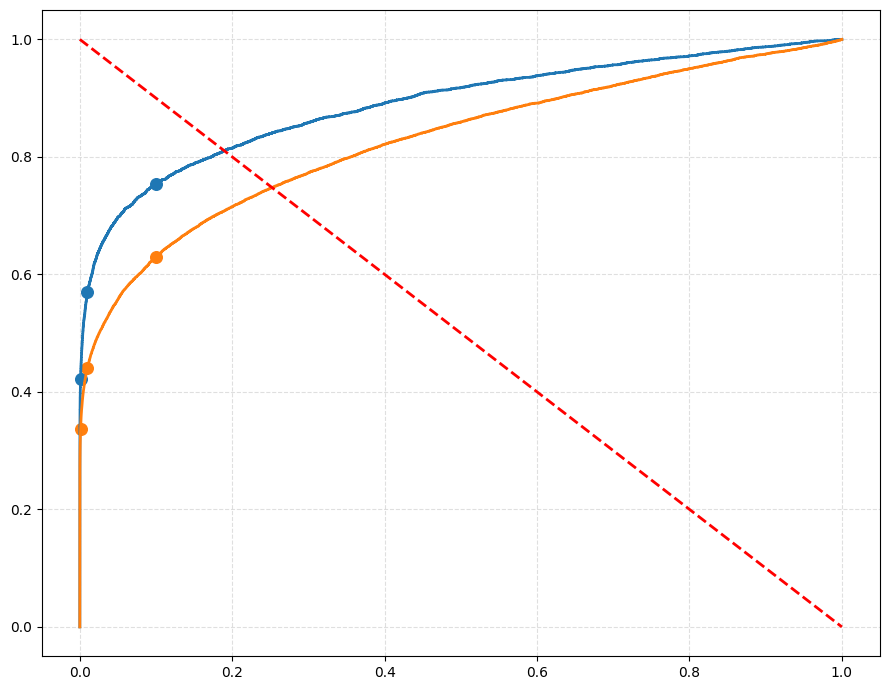

In [22]:
plt.figure(figsize=(9, 7))

# Dataset 1 curve (AFW)
line1, = plt.plot(
    fars_id_pose, tars_id_pose, linewidth=2,
    label=f"AFW (AUC = {auc_id_pose:.4f})"
)
color1 = line1.get_color()

# Dataset 2 curve (MultiPIE)
line2, = plt.plot(
    fpr, tpr, linewidth=2,
    label=f"MultiPIE (AUC = {auc:.4f})"
)
color2 = line2.get_color()

# TAR@FAR markers for AFW
for i, (far, tar) in enumerate(tar_results_id_pose.items()):
    plt.scatter([far], [tar], s=70, color=color1)
    # plt.text(far*1.05, tar + 0.01*i, f"FAR={far}\nTAR={tar:.3f}", fontsize=12, color=color1)

# TAR@FAR markers for MultiPIE
for i, (far, tar) in enumerate(tar_results.items()):
    plt.scatter([far], [tar], s=70, color=color2)
    # plt.text(far*1.05, tar + 0.01*i, f"FAR={far}\nTAR={tar:.3f}", fontsize=12, color=color2)

# Add red negative slope 45° line (y = 1 - x)
x_line = np.linspace(0, 1, 100)
y_line = 1 - x_line
plt.plot(x_line, y_line, 'r--', linewidth=2, label='Negative 45° line')

# Remove axis labels
plt.xlabel("")
plt.ylabel("")

plt.grid(True, linestyle='--', alpha=0.4)
# plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


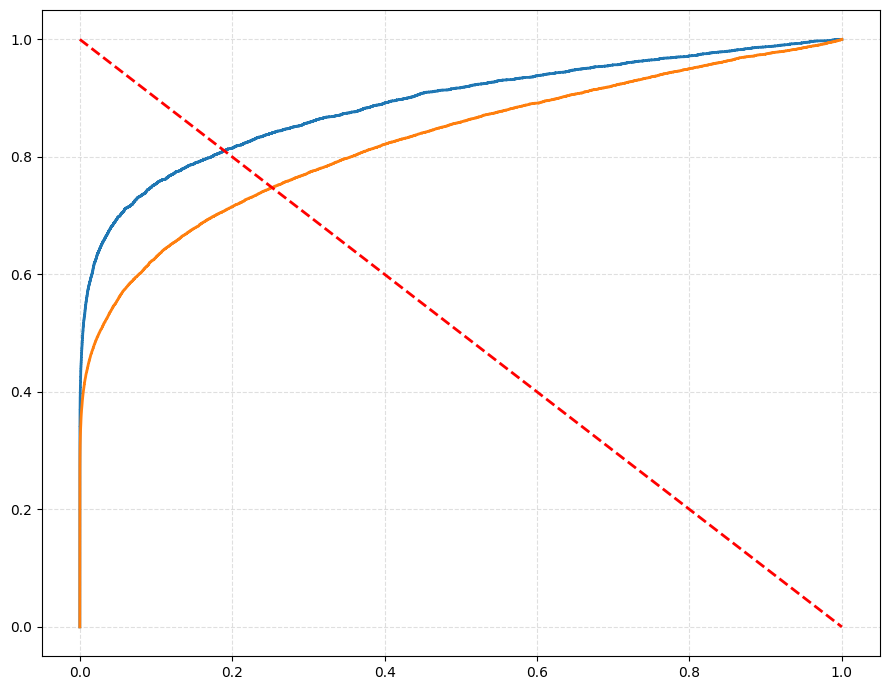

In [24]:
plt.figure(figsize=(9, 7))

# Dataset 1 curve (AFW)
line1, = plt.plot(
    fars_id_pose, tars_id_pose, linewidth=2,
    label=f"AFW (AUC = {auc_id_pose:.4f})"
)
color1 = line1.get_color()

# Dataset 2 curve (MultiPIE)
line2, = plt.plot(
    fpr, tpr, linewidth=2,
    label=f"MultiPIE (AUC = {auc:.4f})"
)
color2 = line2.get_color()

# Add red negative slope 45° line (y = 1 - x)
x_line = np.linspace(0, 1, 100)
y_line = 1 - x_line
plt.plot(x_line, y_line, 'r--', linewidth=2, label='Negative 45° line')

# Remove axis labels
plt.xlabel("")
plt.ylabel("")

plt.grid(True, linestyle='--', alpha=0.4)
# plt.legend(loc="lower right")  # keep legend for clarity
plt.tight_layout()
plt.show()


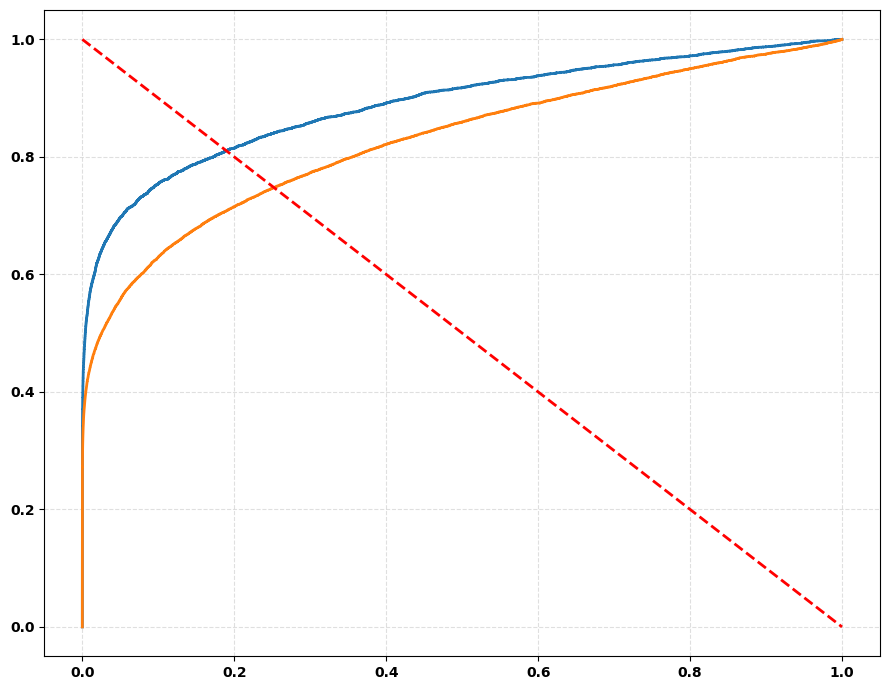

In [26]:
plt.figure(figsize=(9, 7))

# Dataset 1 curve (AFW)
line1, = plt.plot(
    fars_id_pose, tars_id_pose, linewidth=2,
    label=f"AFW (AUC = {auc_id_pose:.4f})"
)
color1 = line1.get_color()

# Dataset 2 curve (MultiPIE)
line2, = plt.plot(
    fpr, tpr, linewidth=2,
    label=f"MultiPIE (AUC = {auc:.4f})"
)
color2 = line2.get_color()

# Add red negative slope 45° line (y = 1 - x)
x_line = np.linspace(0, 1, 100)
y_line = 1 - x_line
plt.plot(x_line, y_line, 'r--', linewidth=2, label='Negative 45° line')

# Remove axis labels
plt.xlabel("")
plt.ylabel("")

# Make tick labels bold
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.4)
# plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

def intersection_neg45(fars, tars):
    fars = np.array(fars)
    tars = np.array(tars)
    # Find index where |TAR - (1 - FAR)| is minimal
    idx = np.argmin(np.abs(tars - (1 - fars)))
    return fars[idx], tars[idx]

# Dataset 1 (AFW)
far_int_afw, tar_int_afw = intersection_neg45(fars_id_pose, tars_id_pose)
print(f"AFW intersection with red line: FAR={far_int_afw:.4f}, TAR={tar_int_afw:.4f}")

# Dataset 2 (MultiPIE)
far_int_multi, tar_int_multi = intersection_neg45(fpr, tpr)
print(f"MultiPIE intersection with red line: FAR={far_int_multi:.4f}, TAR={tar_int_multi:.4f}")


AFW intersection with red line: FAR=0.1891, TAR=0.8108
MultiPIE intersection with red line: FAR=0.2522, TAR=0.7478
